<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/CDAE/CDAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-box

     |████████████████████████████████| 3.0 MB 13.9 MB/s 


In [2]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [3]:
config = {
    'data_path' : "/content/drive/MyDrive/RecsysTutorial/Data/MovieLens" , # 데이터 경로

    'p_dims': [200, 600], 
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,

    'lr' : 0.001,
    'batch_size' : 500,
    'num_epochs' : 200,
    'num_workers' : 2,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [4]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['timestamp']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [5]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

In [6]:
class CDAE(nn.Module):

    def __init__(self, p_dims, user_num, item_num, dropout_rate = 0.5):
        super(CDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        self.user_embedding = nn.Embedding(user_num, item_num)
        
        self.init_weights()
    
    def forward(self, input, user):
        h = F.normalize(input)
        h = self.drop(h)
        h += self.user_embedding(user)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [7]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
        
        if self.model_type == 'VAE':
            KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            loss = loss + anneal * KLD
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

# 4. 학습 함수

In [8]:
def train(model, criterion, optimizer, data_loader, make_matrix_data_set):
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)
        recon_mat = model(mat, users.view(-1).to(device))

        optimizer.zero_grad()
        loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat, users.view(-1).to(device))
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()[::-1]
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

# 5. 학습

In [9]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [10]:
ae_dataset = AEDataSet(
    num_user = make_matrix_data_set.num_user,
    )

In [11]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [13]:
model = CDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item],
    user_num = make_matrix_data_set.num_user, 
    item_num = make_matrix_data_set.num_item,
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [15]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 6299.56372| NDCG@10: 0.00142| HIT@10: 0.00119
Epoch:   2| Train loss: 5858.32788| NDCG@10: 0.00672| HIT@10: 0.00447
Epoch:   3| Train loss: 4141.33923| NDCG@10: 0.04243| HIT@10: 0.02459
Epoch:   4| Train loss: 2177.48639| NDCG@10: 0.08929| HIT@10: 0.05782
Epoch:   5| Train loss: 1037.86902| NDCG@10: 0.09614| HIT@10: 0.06408
Epoch:   6| Train loss: 680.61462| NDCG@10: 0.08980| HIT@10: 0.06408
Epoch:   7| Train loss: 673.86795| NDCG@10: 0.07894| HIT@10: 0.05678
Epoch:   8| Train loss: 602.94702| NDCG@10: 0.08115| HIT@10: 0.06080
Epoch:   9| Train loss: 625.77512| NDCG@10: 0.08847| HIT@10: 0.05797
Epoch:  10| Train loss: 638.10101| NDCG@10: 0.08404| HIT@10: 0.05186
Epoch:  11| Train loss: 632.25745| NDCG@10: 0.08436| HIT@10: 0.05827
Epoch:  12| Train loss: 638.31732| NDCG@10: 0.08856| HIT@10: 0.06170
Epoch:  13| Train loss: 756.10059| NDCG@10: 0.09339| HIT@10: 0.06185
Epoch:  14| Train loss: 590.67993| NDCG@10: 0.09570| HIT@10: 0.06259
Epoch:  15| Train loss: 629.1

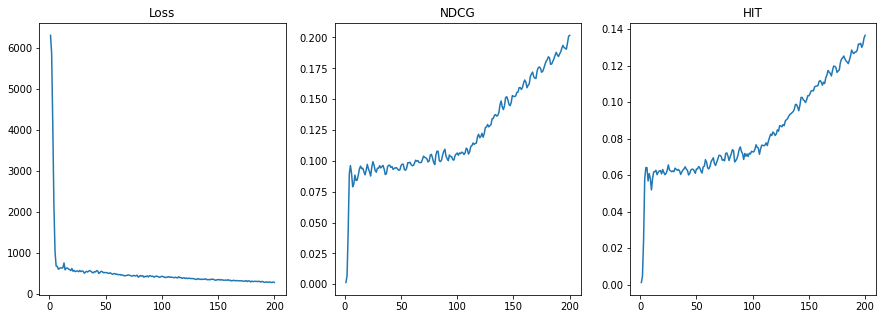

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()